## Extracting all gene names and positions

In [ ]:
import re
import pandas as pd

filename = '/Users/tarunbonu/Tarun/Sem_3/minor_thesis/deep_emscan/data/Homo_sapiens_sample_100.gtf'
# filename = '/home/tbon0008/lz25_scratch/Homo_sapiens.GRCh38.87.gtf'
with open(filename, 'r') as fp:
    gene_data_df = pd.DataFrame(
        columns=['chromosome','gene_name', 'gene_id', 'position_start', 'position_end', 'gene_length', 'gene_source', 'strand'])
    df_ix = 0
    
    line = fp.readline()
    cnt = 1
    
    while line:
        line_elements = line.split('\t')
        if len(line_elements) > 1 and line_elements[2] == 'gene':
#             print(line_elements)
            
            gene_id = re.search(r'gene_id "(.*?)"', line_elements[8]).group(1)
            gene_name = re.search(r'gene_name "(.*?)"', line_elements[8]).group(1)
            gene_source = re.search(r'gene_source "(.*?)"', line_elements[8]).group(1)            
        
            gene_data_df.loc[df_ix] = [line_elements[0], gene_name, gene_id, line_elements[3], line_elements[4], int(line_elements[4])-int(line_elements[3]),gene_source, line_elements[6]]
            df_ix += 1
            
        line = fp.readline()
        cnt += 1
        
gene_data_df
# gene_data_df.to_csv('gene_data.csv', index = False)

In [ ]:
gene_data_df = pd.read_csv('gene_data.csv')
gene_data_df

## Coverting a pwm file with locations to dataframe

In [ ]:
pwm_file = '../data/pwm_tfbs_per_tf/GATA1/ENCSR000EFT.K562.GATA1.MA0035.3.pwm.bed'

with open(pwm_file, 'r') as f1:
    all_lines = f1.readlines()

In [ ]:
all_lines

In [ ]:
pwm_df = pd.DataFrame(
        columns=['tf_name', 'position_start', 'position_end', 'tf_length', 'strand_type', 'tf_seq'])
df_ix = 0
tf_name = pwm_file.split('/')[-2]

for ix in range(0,len(all_lines), 2):
    positions = all_lines[ix].split(':')[1].split('(')
    strand_type = positions[1].split(')')[0]
    positions = positions[0].split('-')
    start_pos = positions[0]
    end_pos = positions[1]
    
#     print(start_pos, end_pos, int(end_pos)-int(start_pos), strand_type, all_lines[ix+1].strip('\n'))
    pwm_df.loc[df_ix] = [tf_name, start_pos, end_pos, int(end_pos)-int(start_pos), strand_type, all_lines[ix+1].strip('\n')]
    df_ix += 1
    
#     if ix == 2:
#         break

In [ ]:
pwm_df

## Look for the binding sites closer to the genes

In [ ]:
for ix, row in gene_data_df.iterrows():
#     print(row)
    gene_name = row['gene_name']
    gene_start_pos = row['position_start']
    gene_end_pos = row['position_end']
    print(gene_name, gene_start_pos, gene_end_pos)
    pwm_df['distance_from_start'] = pwm_df['position_start'].astype(int) - int(gene_start_pos)
    pwm_df['distance_from_end'] = pwm_df['position_end'].astype(int) - int(gene_start_pos)
    
    if not ix:
        break

In [ ]:
pwm_df.sort_values('distance_from_start')

In [ ]:
list(gene_data_df['position_start'].astype(int))[-10000]

In [ ]:
all_lines[0:100]

In [ ]:
with open('../../data/pwm_tfbs_sequences_per_tf/GATA1/ENCSR000EWM.K562.GATA1.MA0035.3.pwm.fa', 'r') as f1:
    all_lines = f1.readlines()
len(all_lines)

In [ ]:
all_lines

## Protein data transformation and extration

In [ ]:
protein_info_path = '../data/9606.protein.info.v11.0.txt'
protein_df = pd.read_csv(protein_info_path, sep='\t', usecols = ['protein_external_id', 'preferred_name'])
protein_df.columns = ['protein_id', 'protein_name']

protein_links_path = '../data/9606.protein.links.detailed.v11.0.txt'
protein_links_df = pd.read_csv(protein_links_path, sep = ' ', usecols = ['protein1', 'protein2', 'combined_score'])
protein_links_df.columns = ['protein1_id', 'protein2_id', 'combined_score']

protein_links_df = pd.merge(protein_links_df, protein_df, how='left',left_on=['protein1_id'],right_on=['protein_id'])
protein_links_df = pd.merge(protein_links_df, protein_df, how='left',left_on=['protein2_id'],right_on=['protein_id'])
protein_links_df = protein_links_df[['protein_name_x', 'protein_name_y', 'combined_score']]
del protein_df

protein_links_df.to_csv('../data/9606.protein_links_names.csv', index = False)
del protein_links_df

## DNA shapes data extraction

In [ ]:
import pandas as pd
import urllib.request

In [ ]:
download_url = 'ftp://rohslab.usc.edu/hg38/'

with urllib.request.urlopen(download_url) as r:
    data = r.read()

data = data.decode('ascii')

In [ ]:
DNA_shape_files = [file for file in [line.split(' ')[-1].strip('\r') for ix, line in enumerate(data.split('\n')) if line and ix>0] if '2' not in file and 'wig.bw' not in file and 'wig' in file]
DNA_shape_files

In [ ]:
shapes = [file.split('.')[1] for file in DNA_shape_files]
print(shapes)

In [ ]:
url_links = [download_url + file for file in DNA_shape_files]
url_links

# Dataset generation

## Data generation for a pair of motifs

In [ ]:
import os
import numpy as np
import pandas as pd

gene_data_df = pd.read_csv('../data/gene_data.csv')
gene_data_df['chromosome'] = 'chr' + gene_data_df['chromosome']

motif1_path = '../data/pwm_tfbs_per_tf/GATA1/'
motif2_path = '../data/pwm_tfbs_per_tf/TAL1/'
motif1 = motif1_path.split('/')[-2]
motif2 = motif2_path.split('/')[-2]
print(motif1, motif2)

data_save_path = '../data/'+ motif1 + '_' + motif2 + '/'
if not os.path.isdir(data_save_path):
    os.mkdir(data_save_path)

chromosomes_considered = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chrX',
       'chr8', 'chr9', 'chr11', 'chr10', 'chr12', 'chr13', 'chr14',
       'chr15', 'chr16', 'chr17', 'chr18', 'chr20', 'chr19', 'chrY',
       'chr22', 'chr21']

def join_binding_sites(motif_filepath):
    col_names = ['chromosome', 'start_pos', 'end_pos', 'bs_seq', 'score', 'strand']
    motif_df = pd.DataFrame(columns=col_names)

    for rootpath, dirpath, filenames  in os.walk(motif_filepath):
        for filename in filenames:
            filepath = rootpath + filename
            temp_df = pd.read_csv(filepath, sep='\t',names = col_names)
            motif_df = pd.concat([motif_df, temp_df], ignore_index=True)
            
    return motif_df

motif1_df = join_binding_sites(motif1_path)
print(motif1_df.shape)

motif2_df = join_binding_sites(motif2_path)
print(motif2_df.shape)

motif1_df = motif1_df[motif1_df['chromosome'].isin(chromosomes_considered)]
motif2_df = motif2_df[motif2_df['chromosome'].isin(chromosomes_considered)]
gene_data_df = gene_data_df[gene_data_df['chromosome'].isin(chromosomes_considered)]

print(motif1_df.shape)
print(motif2_df.shape)

In [ ]:
motif1_df.drop_duplicates(subset=['chromosome', 'bs_seq', 'start_pos', 'strand'], inplace = True)
motif1_df = motif1_df.reset_index(drop = True)
motif1_df['index'] = motif1_df.index
motif1_df.to_csv(data_save_path + '/' + motif1 + '_sequences.csv', index = False)

motif2_df.drop_duplicates(subset=['chromosome', 'bs_seq', 'start_pos', 'strand'], inplace = True)
motif2_df = motif2_df.reset_index(drop = True)
motif2_df['index'] = motif2_df.index
motif2_df.to_csv(data_save_path + '/' + motif2 + '_sequences.csv', index = False)

In [ ]:
# for chromosome in chromosomes_considered:

chromosome = 'chr1'

temp1_df = motif1_df[motif1_df['chromosome'] == chromosome]

df_cols = [motif1 + '_ix', motif2 + '_ix', 'dbbs']
_1k_df = pd.DataFrame(columns = df_cols)
_1k_5k_df = pd.DataFrame(columns = df_cols)
_5k_10k_df = pd.DataFrame(columns = df_cols)
_summary_df = pd.DataFrame(columns=[motif1 + '_ix', '_1k', '1k_5k', '5k_10k', '10k_'])

for ix, row in temp1_df.iterrows():
    bs1_index = row['index']
    temp2_df = motif2_df[motif2_df['chromosome'] == chromosome]
    temp2_df = temp2_df[temp2_df['strand'] == row['strand']]
    temp2_df[motif1 + '_ix'] = [bs1_index] * len(temp2_df)
    temp2_df['dbbs'] = abs(int(row['start_pos']) - temp2_df['start_pos'].astype(int))
    temp2_df.rename(columns={'index': motif2 + '_ix'}, inplace=True)
    temp2_df = temp2_df[df_cols]

    _1k_temp_df = temp2_df[temp2_df['dbbs'] <= 1000]
    _1k_df = pd.concat([_1k_df,_1k_temp_df], axis=0).reset_index(drop=True)

    _1k_5k_temp_df = temp2_df[(temp2_df['dbbs'] > 1000) & (temp2_df['dbbs'] <= 5000)]
    _1k_5k_df = pd.concat([_1k_5k_df,_1k_5k_temp_df], axis=0).reset_index(drop=True)

    _5k_10k_temp_df = temp2_df[(temp2_df['dbbs'] > 5000) & (temp2_df['dbbs'] <= 10000)]
    _5k_10k_df = pd.concat([_5k_10k_df,_5k_10k_temp_df], axis=0).reset_index(drop=True)

    _summary_temp_df = pd.DataFrame(columns=[motif1 + '_ix', '_1k', '1k_5k', '5k_10k', '10k_'])
    _summary_temp_df.loc[0] = [bs1_index, len(_1k_temp_df), len(_1k_5k_temp_df), len(_5k_10k_temp_df),
                               len(temp2_df[temp2_df['dbbs'] > 10000])]
    _summary_df = pd.concat([_summary_df,_summary_temp_df], axis=0).reset_index(drop=True)

    _1k_df.to_csv(data_save_path + '_1k_co_occurrence.csv', index = False)
    _1k_5k_df.to_csv(data_save_path + '1k_5k_co_occurrence.csv', index = False)
    _5k_10k_df.to_csv(data_save_path + '5k_10k_co_occurrence.csv', index = False)
    _summary_df.to_csv(data_save_path + 'summary_co_occurrence.csv', index = False)


#     _5k_10k_df = pd.DataFrame(columns = df_cols)


    if ix % 100 == 0:
        print('Row number is ' , ix, ' and the perc is ', ix/len(temp1_df) , end = '\r')

# _summary_df

### Alternative method

In [ ]:
co_occurrence_df = pd.DataFrame(
        columns=['chr','bs1_seq', 'bs2_seq', 'dbbs', 'ng', 'dng', 'strd1_strd2'])

chromosome = 'chr1'

temp1_df = motif1_df[motif1_df['chromosome'] == chromosome]
temp2_df = motif2_df[motif2_df['chromosome'] == chromosome]
temp2_df_len = len(temp2_df)

for ix, row1 in temp1_df.iterrows():
    temp_gene_df = gene_data_df[gene_data_df['chromosome'] == chromosome]

    temp_gene_df.loc[:,"distance"] = np.nan
    temp_gene_df.loc[temp_gene_df['strand'] == row1['strand'], 'distance'] = temp_gene_df['position_start'].astype(int) - int(row1['start_pos'])
    temp_gene_df.loc[temp_gene_df['strand'] != row1['strand'], 'distance'] = int(row1['end_pos']) - temp_gene_df['position_start'].astype(int)

    temp_gene_df = temp_gene_df[temp_gene_df['distance'] > 0]
    temp_gene_df['distance'] = temp_gene_df['distance'].astype(int)
    temp_gene_df = temp_gene_df.sort_values('distance').reset_index()
    
    temp_co_occurrence_df = pd.DataFrame(
        columns=['chr','bs1_seq', 'bs2_seq', 'dbbs', 'ng', 'dng', 'strd1_strd2'])
    temp_co_occurrence_df['bs2_seq'] = temp2_df['bs_seq']
    temp_co_occurrence_df['dbbs'] = abs(int(row1['start_pos']) - temp2_df['start_pos'].astype(int))
    temp_co_occurrence_df['strd1_strd2'] = row1['strand'] + '_' + temp2_df['strand']
    temp_co_occurrence_df['chr'] = [chromosome] * temp2_df_len
    temp_co_occurrence_df['bs1_seq'] = [row1['bs_seq']] * temp2_df_len
    temp_co_occurrence_df['ng'] = [temp_gene_df.loc[0,'gene_name']] * temp2_df_len
    temp_co_occurrence_df['dng'] = [temp_gene_df.loc[0,'distance']] * temp2_df_len
    
    co_occurrence_df = pd.concat([co_occurrence_df,temp_co_occurrence_df], axis=0)

    if ix:
        break
        
print(co_occurrence_df.shape)
co_occurrence_df


In [ ]:
co_occurrence_df.sort_values('dbbs').reset_index()

## Data aggregation and transformation

In [580]:
def get_skew_score(bs_seq):
    
    bs_seq = bs_seq.lower()
    a_count = bs_seq.count('a')
    g_count = bs_seq.count('g')
    c_count = bs_seq.count('c')
    t_count = bs_seq.count('t')
    
    if ((g_count+c_count) == 0 or (a_count+t_count) == 0):
        return((g_count-c_count)/(g_count+c_count + 1), (a_count-t_count)/(a_count+t_count + 1))
    else:
        return((g_count-c_count)/(g_count+c_count), (a_count-t_count)/(a_count+t_count))
        

In [ ]:
data_save_path = '../data/GATA1_TAL1/'
motif1, motif2 = data_save_path.split('/')[-2].split('_')

_1k_df = pd.read_csv(data_save_path + '_1k_co_occurrence.csv')
motif1_df = pd.read_csv(data_save_path + '/' + motif1 + '_sequences.csv')
motif2_df = pd.read_csv(data_save_path + '/' + motif2 + '_sequences.csv')

_1k_df = pd.merge(_1k_df, motif1_df, how = 'left', left_on= motif1 + '_ix', right_on= 'index')
_1k_df.rename(columns = {'bs_seq' : motif1 + '_seq'}, inplace = True)
_1k_df.drop(['index', 'end_pos', 'score'], axis=1, inplace= True)
_1k_df = pd.merge(_1k_df, motif2_df[['index', 'bs_seq']], how = 'left', left_on= motif2 + '_ix', right_on= 'index')
_1k_df.rename(columns = {'bs_seq' : motif2 + '_seq'}, inplace = True)
_1k_df.drop(['index'], axis=1, inplace= True)

_summary_df = pd.read_csv(data_save_path + 'summary_co_occurrence.csv')
_1k_df = pd.merge(_1k_df, _summary_df, how = 'left', on= motif1 + '_ix')

_1k_df['total'] = _1k_df['_1k'] + _1k_df['1k_5k'] + _1k_df['5k_10k'] + _1k_df['10k_']
fr = (sum(_1k_df['_1k']) + sum(_1k_df['1k_5k'])) / sum(_1k_df['total'])
_1k_df['fr'] = fr

protein_path = '../data/9606.protein_links_names.csv'
protein_df = pd.read_csv(protein_path)
ppi_score = protein_df[(protein_df['protein_name_y'] == motif1) & (protein_df['protein_name_x'] == motif2)].iloc[0]['combined_score']
_1k_df['ppi_score'] = ppi_score

gene_names = []
gene_distances = []
at_skew = []
gc_skew = []

shapes = ['Rise', 'Roll', 'Shift', 'Slide', 'Tilt']
shape_files = ['../data/DNA_shapes/hg38.' + shape + '.wig' for shape in shapes]

motif1_len = len(motif1_df.loc[0]['bs_seq'].split('_')[1])
motif_mid = int(np.ceil(motif1_len/2))
shape_vals = np.zeros((len(_1k_df),5))

for ix, row in _1k_df.iterrows():
    
    start_pos = int(row['start_pos'])
    chromosome = row['chromosome']
    strand = row['strand']
    
    temp_gene_df = gene_data_df[(gene_data_df['chromosome'] == chromosome) & (gene_data_df['strand'] == strand)]
    temp_gene_df = temp_gene_df.assign(distance = temp_gene_df['position_start'].astype(int) - start_pos)
    temp_gene_df = temp_gene_df[temp_gene_df['distance'] > 0]
    temp_gene_df['distance'] = temp_gene_df['distance'].astype(int)
    temp_gene_df = temp_gene_df.sort_values('distance').reset_index(drop = True)
    try:
        gene_names.append(temp_gene_df.loc[0,'gene_name'])
        gene_distances.append(temp_gene_df.loc[0,'distance'])
    except:
        gene_names.append(np.NaN)
        gene_distances.append(np.NaN)
        
    DNA_start = start_pos + motif_mid - 15
    for jx, shape_file in enumerate(shape_files):
#         shape_vals[ix, jx] = get_shape_score(shape_file, DNA_start, chromosome)
        shape_vals[ix,jx] = round(np.random.rand(),2)
    
    gc, at = get_skew_score(row[motif2 + '_seq'].split('_')[1]) # Check the calculation again
    gc_skew.append(round(gc, 2))
    at_skew.append(round(at, 2))

_1k_df['ng'] = gene_names
_1k_df['dng'] = gene_distances
_1k_df['at_skew'] = at_skew
_1k_df['gc_skew'] = gc_skew

for ix, shape in enumerate(shapes):
    column_name = shape.lower() + '_score'
    _1k_df[column_name] = shape_vals[:,ix]
    
_1k_df.drop([motif1 + '_seq', motif2 + '_seq', '_1k', '1k_5k', 'total', '5k_10k', '10k_'], 
            axis=1, inplace= True)

_1k_df

In [ ]:
_1k_df.to_csv(data_save_path + '1k_data_features.csv', index = False)

In [ ]:
!pip install numpy

## EDA on data generated

### Histograms

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
_1k_df = pd.read_csv('../data/GATA1_TAL1/_1k_co_occurrence.csv')
plt.hist(_1k_df['dbbs'], bins = 50)
plt.xlabel('dbbs')
plt.ylabel('Count')
plt.title('Histogram of counts less than 1000bp')
plt.show()

In [ ]:
_1k_5k_df = pd.read_csv('../data/GATA1_TAL1/1k_5k_co_occurrence.csv')
plt.hist(_1k_5k_df['dbbs'], bins = 50)
plt.xlabel('dbbs')
plt.ylabel('Count')
plt.title('Histogram of counts for 1000bp to 5000bp')
plt.show()

In [ ]:
_5k_10k_df = pd.read_csv('../data/GATA1_TAL1/5k_10k_co_occurrence.csv')
plt.hist(_5k_10k_df['dbbs'], bins = 50)
plt.xlabel('dbbs')
plt.ylabel('Count')
plt.title('Histogram of counts for 5000bp to 10000bp')
plt.show()

In [ ]:
_1k_df['dbbs'].value_counts().reset_index().rename(columns = {'index': 'dbbs', 'dbbs': 'count'}).head(20)

In [ ]:
summary_df = pd.read_csv('../data/GATA1_TAL1/summary_co_occurrence.csv')

In [ ]:
summary_df['total'] = summary_df['_1k'] + summary_df['1k_5k'] + summary_df['5k_10k'] + summary_df['10k_']

In [ ]:
sum(summary_df['total'])

In [ ]:
motif1_df

### Search for other motifs

In [107]:
import os
import numpy as np
import pandas as pd

data_df = pd.read_csv('../data/GATA1_TAL1/1k_data_features.csv')

gene_data_df = pd.read_csv('../data/gene_data.csv')
gene_data_df['chromosome'] = 'chr' + gene_data_df['chromosome']

In [108]:
data_df

GATA1_ix  TAL1_ix  dbbs chromosome  start_pos strand        fr  \
0             0    20198    14       chr1    1005109      +  0.000575   
1             0    44668     2       chr1    1005109      +  0.000575   
2             1    44677     2       chr1    1847202      +  0.000575   
3             3    20201    66       chr1    1858854      -  0.000575   
4             3    44678     9       chr1    1858854      -  0.000575   
...         ...      ...   ...        ...        ...    ...       ...   
42123    141855    82794   121      chr21   42462804      +  0.000575   
42124    141858    57587   487      chr21   42764292      +  0.000575   
42125    141860    57589     2      chr21   42796559      +  0.000575   
42126    141877    25136   125      chr21   45383377      +  0.000575   
42127    141877   111883     2      chr21   45383377      +  0.000575   

       ppi_score           ng       dng  at_skew  gc_skew  rise_score  \
0            994         AGRN   15014.0    -0.20    -0.14        0.35   
1            994         AGRN   15014.0     0.27    -0.14        0.19   
2            994  RP1-140A9.1   44269.0    -0.09    -0.43        0.86   
3            994       TMEM52   58736.0     0.60     0.43        0.43   
4            994       TMEM52   58736.0     0.00     0.50        0.13   
...          ...          ...       ...      ...      ...         ...   
42123        994      SLC37A1   33204.0    -0.33     0.00        0.69   
42124        994       NDUFV3  115352.0     0.20     0.25        0.52   
42125        994       NDUFV3   83085.0     0.11    -0.33        0.11   
42126        994      COL18A1   21760.0    -0.25     0.00        0.64   
42127        994      COL18A1   21760.0    -0.60    -0.25        0.91   

       roll_score  shift_score  slide_score  tilt_score  
0            0.44         0.20         0.65        0.70  
1            0.40         0.91         0.91        0.35  
2            0.28         0.85         0.65        0.29  
3            0.80         0.69         0.58        0.46  
4            0.36         0.76         0.26        0.07  
...           ...          ...          ...         ...  
42123        0.87         0.29         0.69        0.26  
42124        0.12         0.01         0.49        0.92  
42125        0.09         0.01         0.96        0.43  
42126        0.48         0.82         0.08        0.40  
42127        0.03         0.39         0.35        0.95  

[42128 rows x 17 columns]

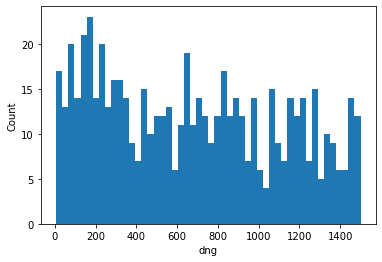

In [109]:
data_save_path = '../data/GATA1_TAL1/'
motif1, motif2 = data_save_path.split('/')[-2].split('_')

motif1_df = pd.read_csv(data_save_path + '/' + motif1 + '_sequences.csv')
motif2_df = pd.read_csv(data_save_path + '/' + motif2 + '_sequences.csv')

# data_df = pd.merge(data_df, motif1_df, how = 'left', left_on= motif1 + '_ix', right_on= 'index')
# data_df[data_df['dbbs'] <= 50]
temp1 = data_df[(data_df['dbbs'] <= 30) & (data_df['dng'] <= 1500)]

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(temp1['dng'], bins = 50)
plt.xlabel('dng')
plt.ylabel('Count')
plt.show()

In [110]:
len(pd.unique(temp1['ng']))

487

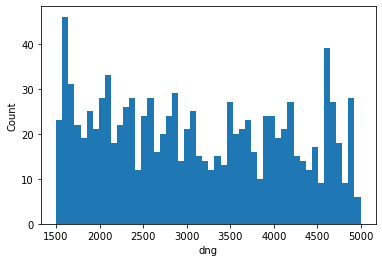

In [111]:
temp2 = data_df[(data_df['dbbs'] <= 30) & (data_df['dng'] <= 5000) & (data_df['dng'] > 1500)]

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(temp2['dng'], bins = 50)
plt.xlabel('dng')
plt.ylabel('Count')
plt.show()

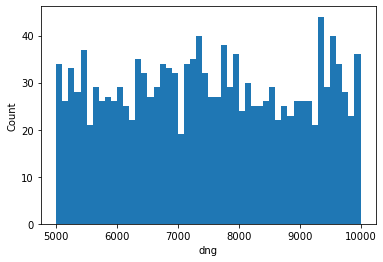

In [112]:
temp3 = data_df[(data_df['dbbs'] <= 30) & (data_df['dng'] <= 10000) & (data_df['dng'] > 5000)]

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(temp3['dng'], bins = 50)
plt.xlabel('dng')
plt.ylabel('Count')
plt.show()

In [114]:
# Unique gene occurrences
temp1 = temp1[['ng', 'chromosome', 'strand']]
temp1 = temp1.drop_duplicates().reset_index(drop = True)
temp1

ng chromosome strand
0           PITHD1       chr1      +
1          GPATCH3       chr1      -
2           SLC2A1       chr1      -
3    RP11-191G24.1       chr1      +
4      RP4-735C1.6       chr1      +
..             ...        ...    ...
488           LTN1      chr21      -
489         ADARB1      chr21      +
490     UMODL1-AS1      chr21      -
491           RRP1      chr21      +
492      LINC00315      chr21      -

[493 rows x 3 columns]

In [101]:
temp1 = gene_data_df[gene_data_df['gene_name'].isin(['NKILA', 'SOCS-AS1', 'LINC01116', 'LINC000312'])]
temp1 = temp1.rename(columns = {'gene_name': 'ng'})


temp1 = temp1[['ng', 'chromosome', 'strand']]
temp1

ng chromosome strand
8048   LINC01116       chr2      -
52154      NKILA      chr20      +

In [118]:
all_motifs_filepath = '../data/pwm_tfbs_per_tf/'
all_motif_paths = []
for rootpath, dirpath, filenames  in os.walk(all_motifs_filepath):
    for folder in dirpath:
        all_motif_paths.append(rootpath + folder + '/')


all_motif_dfs = {}
all_motifs = []
for ix, motif_path in enumerate(all_motif_paths):
    motif_df = join_binding_sites(motif_path)
    motif_df.drop_duplicates(subset=['chromosome', 'bs_seq', 'start_pos', 'strand'], inplace = True)
    motif_df['start_pos'] = motif_df['start_pos'].astype(int)
    motif_df = motif_df.reset_index(drop = True)
    motif = motif_path.split('/')[3]
    all_motifs.append(motif)
    all_motif_dfs[motif] = motif_df
    print('Percentage completed: ', round(ix/len(all_motif_paths) * 100, 0), end = '\r')
    
print()
print(all_motifs)
print('Gene extraction start..')
print()

start_positions = []
nearest_motifs = []

for ix,row in temp1.iterrows():
    nearest_motif = {}
    gene = row['ng']
    chromosome = row['chromosome']
    strand = row['strand']
    start_pos = gene_data_df[(gene_data_df['gene_name'] == gene) &
                            (gene_data_df['chromosome'] == chromosome) &
                            (gene_data_df['strand'] == strand)]['position_start']
    
    for position in start_pos:
        for motif in all_motifs:
            motif_df = all_motif_dfs[motif]
            motif_df = motif_df[(motif_df['chromosome'] == chromosome) &
                                (motif_df['strand'] == strand)]
            motif_df['dng'] = int(position) - motif_df['start_pos']
            motif_df = motif_df[(motif_df['dng'] >= 0) &
                                (motif_df['dng'] <= 1500)]

            if motif_df.shape[0]:
                for jx, row2 in motif_df.iterrows():
#                     print(row2)
#                     nearest_motif[row2['bs_seq']] = row2['dng']
                    nearest_motif[row2['bs_seq']] = row2['start_pos']
    
    start_positions.append(position)
    nearest_motifs.append(nearest_motif)
    
    print(gene, 'Percentage completed: ', round(ix/len(temp1) * 100, 0), end = '\r')
#     if not ix:
#         break

temp1['gene_start_pos'] = start_positions
temp1['nearest_motifs'] = nearest_motifs


['SP2', 'NR1H4', 'NR1H3', 'RUNX2', 'ELF5', 'CUX1', 'PBX2', 'ELF4', 'SNAI2', 'FOXP2', 'PBX3', 'RARA', 'RUNX3', 'ELF3', 'SP4', 'NR1H2', 'MAF', 'NR5A2', 'ZFX', 'NFE2L1', 'FOSL1', 'LHX2', 'BATF', 'PDX1', 'RBPJ', 'TEAD2', 'CREB3L1', 'GFI1B', 'SIX2', 'NR2F2', 'NFKB1', 'POU4F2', 'RELB', 'PKNOX1', 'BACH2', 'MXI1', 'IRF4', 'HES1', 'IRF3', 'ATF3', 'SOX9', 'ATF4', 'NFYB', 'E2F4', 'TEAD4', 'FOXK2', 'SREBF2', 'PRDM1', 'FOXA2', 'IRF2', 'TFDP1', 'POU2F1', 'SOX6', 'TWIST1', 'HSF1', 'HINFP', 'RFX1', 'MYOD1', 'MAFF', 'TP53', 'ERG', 'NRF1', 'KLF4', 'CEBPA', 'CREB1', 'ZBTB33', 'ZEB1', 'HOXA9', 'PAX5', 'ZNF263', 'TP63', 'KLF5', 'CEBPG', 'KLF13', 'MAFG', 'MEF2A', 'ESR1', 'NR4A1', 'ARNTL', 'TFAP2A', 'SOX10', 'SRF', 'TCF3', 'NFE2', 'LEF1', 'TCF4', 'STAT3', 'DUX4', 'ONECUT1', 'GABPA', 'TBP', 'POU5F1', 'SPI1', 'USF1', 'JUNB', 'POU3F2', 'CREM', 'MEIS1', 'MYBL2', 'T', 'TCF7L2', 'SOX11', 'ETV6', 'ESRRA', 'TAL1', 'STAT5A', 'TFAP4', 'ETV1', 'ELK4', 'JUND', 'PPARG', 'GATA1', 'GATA6', 'STAT2', 'MAX', 'EHF', 'AHR', 'H

<ipython-input-118-fafcd4c7380a>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motif_df['dng'] = int(position) - motif_df['start_pos']


In [123]:
temp1.to_csv('../data/GATA1_TAL1/motif_search.csv', index = False)

### EDA on cooccurring pairs data

In [599]:
import json
import pandas as pd

temp1 = pd.read_csv('../data/GATA1_TAL1/motif_search.csv')
temp1.head()

ng chromosome strand  gene_start_pos  \
0         PITHD1       chr1      +        23778405   
1        GPATCH3       chr1      -        26890488   
2         SLC2A1       chr1      -        42925375   
3  RP11-191G24.1       chr1      +        51518309   
4    RP4-735C1.6       chr1      +       109828355   

                                      nearest_motifs  
0  {'ATF3_TACGACGC': 23778391, 'FOXK2_AAAGAAACGTG...  
1  {'PBX3_GCCAGCGTCACTCGCCT': 26890204, 'ZFX_AAGG...  
2  {'GFI1B_GGGTGTGATTG': 42924332, 'MXI1_GACCACGC...  
3  {'SNAI2_GGCAGGTGT': 51518159, 'PBX3_GTGTGAGTGA...  
4  {'GFI1B_AAATCACAGct': 109826866, 'TEAD4_ttctta...

In [600]:
genes = []
counts = []
distance_vals = []
less_50_distance_vals = []

for ix, row in temp1.iterrows():
    distances = {}
    less_50_distances = {}
    
    genes.append(row['ng'])
    gene_pos = row['gene_start_pos']
    nearest_motifs = row['nearest_motifs']
    nearest_motifs = json.loads(nearest_motifs.replace("'", "\""))
    
    count = len(nearest_motifs)
    counts.append(count)
    
    for key1, value1 in nearest_motifs.items():
        for key2, value2 in nearest_motifs.items():
            if key1 == key2:
                continue
            if key1 < key2:
                distance = abs(int(value1) - int(value2))
#                 print(distance)
                distances[key1 + '_' +key2] = distance
                if distance <= 50:
                    less_50_distances[key1 + '_' +key2] = distance
                
    distance_vals.extend(list(distances.values()))
    less_50_distance_vals.extend(list(less_50_distances.values()))
    
#     if not ix:
#         break
        
print(len(distance_vals))
print(len(less_50_distance_vals))

221118
46890


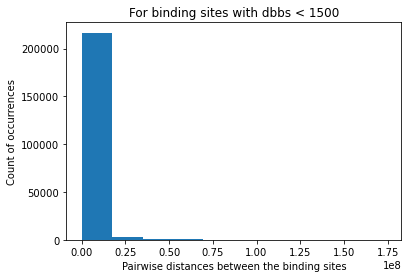

In [601]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(distance_vals, bins = 10)
plt.xlabel('Pairwise distances between the binding sites')
plt.ylabel('Count of occurrences')
plt.title('For binding sites with dbbs < 1500')
plt.show()

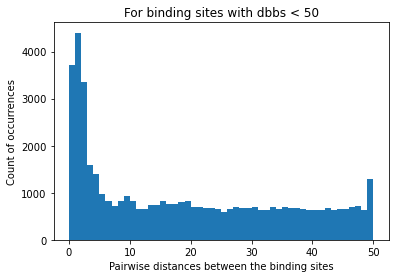

In [602]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(less_50_distance_vals, bins = 50)
plt.xlabel('Pairwise distances between the binding sites')
plt.ylabel('Count of occurrences')
plt.title('For binding sites with dbbs < 50')
plt.show()

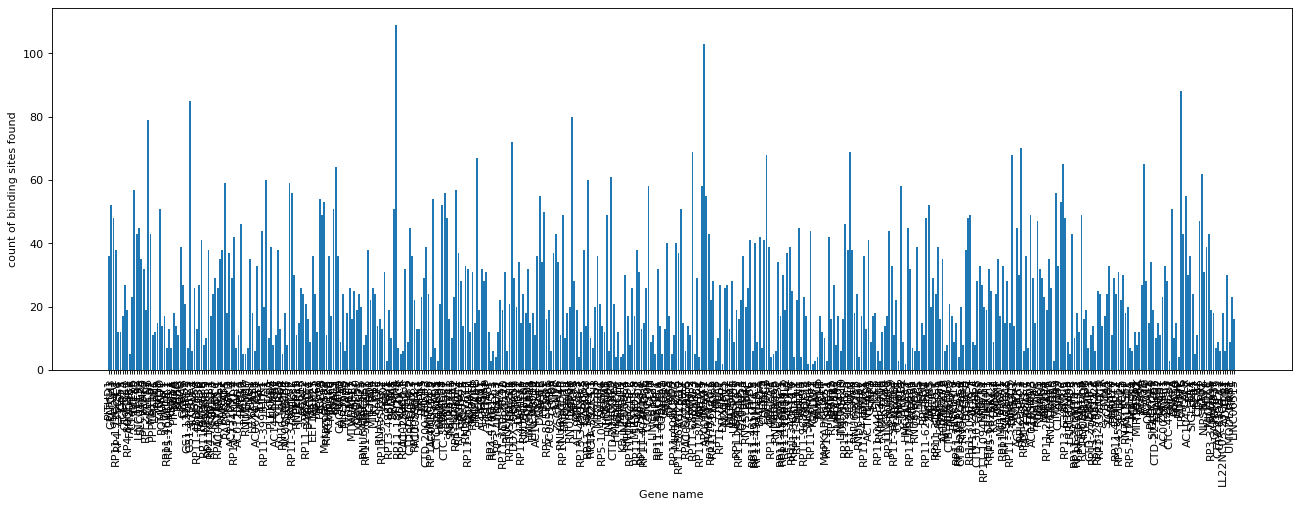

In [603]:
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

plt.bar(genes, counts)
plt.xticks(rotation = 90)
plt.xlabel("Gene name")
plt.ylabel("count of binding sites found")
plt.show()

In [604]:
average = sum(counts) / len(counts)
average

24.754563894523326

In [605]:
data_df[(data_df['dbbs'] <= 50) & (data_df['dng'] <= 1500)]

GATA1_ix  TAL1_ix  dbbs chromosome  start_pos strand        fr  \
156         146    20306    32       chr1   23778068      +  0.000575   
188         186    20326    26       chr1   26890254      -  0.000575   
189         186    45013     9       chr1   26890254      -  0.000575   
190         186    83469    34       chr1   26890254      -  0.000575   
354         338    45261     9       chr1   42925081      -  0.000575   
...         ...      ...   ...        ...        ...    ...       ...   
41754      6667    25131     8      chr21   45073624      +  0.000575   
41989     71459    38286    12      chr21   42101502      -  0.000575   
42024     71541    25120     0      chr21   43788619      +  0.000575   
42025     71541    57602     2      chr21   43788619      +  0.000575   
42061    121237    57626     9      chr21   45299665      -  0.000575   

       ppi_score          ng    dng  at_skew  gc_skew  rise_score  roll_score  \
156          994      PITHD1  337.0     0.33     0.00        0.48        0.35   
188          994     GPATCH3  234.0     0.67     0.00        0.32        0.26   
189          994     GPATCH3  234.0     0.78     0.11        0.33        0.87   
190          994     GPATCH3  234.0     0.20    -0.14        0.37        0.44   
354          994      SLC2A1  294.0     0.33     0.33        0.08        0.20   
...          ...         ...    ...      ...      ...         ...         ...   
41754        994      ADARB1  229.0    -0.25    -0.50        0.66        0.26   
41989        994  UMODL1-AS1  632.0    -0.50     0.50        0.70        0.45   
42024        994        RRP1  894.0    -0.43    -0.20        0.83        0.04   
42025        994        RRP1  894.0     0.00    -0.67        0.75        0.62   
42061        994   LINC00315  580.0    -0.11    -0.11        0.28        0.71   

       shift_score  slide_score  tilt_score  
156           0.12         0.04        0.11  
188           0.28         0.96        0.99  
189           0.15         0.04        0.55  
190           0.15         0.10        0.89  
354           0.68         0.75        0.05  
...            ...          ...         ...  
41754         0.35         0.70        0.21  
41989         0.14         0.98        0.04  
42024         0.91         0.87        0.02  
42025         1.00         0.80        1.00  
42061         0.85         0.22        0.03  

[614 rows x 17 columns]

In [606]:
temp1

ng chromosome strand  gene_start_pos  \
0           PITHD1       chr1      +        23778405   
1          GPATCH3       chr1      -        26890488   
2           SLC2A1       chr1      -        42925375   
3    RP11-191G24.1       chr1      +        51518309   
4      RP4-735C1.6       chr1      +       109828355   
..             ...        ...    ...             ...   
488           LTN1      chr21      -        28928144   
489         ADARB1      chr21      +        45073853   
490     UMODL1-AS1      chr21      -        42102134   
491           RRP1      chr21      +        43789513   
492      LINC00315      chr21      -        45300245   

                                        nearest_motifs  
0    {'ATF3_TACGACGC': 23778391, 'FOXK2_AAAGAAACGTG...  
1    {'PBX3_GCCAGCGTCACTCGCCT': 26890204, 'ZFX_AAGG...  
2    {'GFI1B_GGGTGTGATTG': 42924332, 'MXI1_GACCACGC...  
3    {'SNAI2_GGCAGGTGT': 51518159, 'PBX3_GTGTGAGTGA...  
4    {'GFI1B_AAATCACAGct': 109826866, 'TEAD4_ttctta...  
..                                                 ...  
488  {'TEAD4_ctgataagac': 28927314, 'TAL1_cttaaaaat...  
489  {'PBX3_CTGCTAGTGTCAGTGCG': 45073812, 'E2F4_CGG...  
490  {'HSF1_GAAGACTCTAGAA': 42101012, 'TAL1_TGCAGGT...  
491  {'SP2_GTTCCGCCCATGCGC': 43789395, 'PBX2_atgatt...  
492  {'PBX2_ATCAACAATCAA': 45299533, 'FOXA2_TTTATGT...  

[493 rows x 5 columns]

In [607]:
protein_path = '../data/9606.protein_links_names.csv'
protein_df = pd.read_csv(protein_path)

protein_df.head()

protein_name_x protein_name_y  combined_score
0           ARF5          CALM2             490
1           ARF5        ARHGEF9             198
2           ARF5           ERN1             159
3           ARF5         CDKN2A             606
4           ARF5           P4HB             167

In [643]:
temp1

ng chromosome strand  gene_start_pos  \
0           PITHD1       chr1      +        23778405   
1          GPATCH3       chr1      -        26890488   
2           SLC2A1       chr1      -        42925375   
3    RP11-191G24.1       chr1      +        51518309   
4      RP4-735C1.6       chr1      +       109828355   
..             ...        ...    ...             ...   
488           LTN1      chr21      -        28928144   
489         ADARB1      chr21      +        45073853   
490     UMODL1-AS1      chr21      -        42102134   
491           RRP1      chr21      +        43789513   
492      LINC00315      chr21      -        45300245   

                                        nearest_motifs  
0    {'ATF3_TACGACGC': 23778391, 'FOXK2_AAAGAAACGTG...  
1    {'PBX3_GCCAGCGTCACTCGCCT': 26890204, 'ZFX_AAGG...  
2    {'GFI1B_GGGTGTGATTG': 42924332, 'MXI1_GACCACGC...  
3    {'SNAI2_GGCAGGTGT': 51518159, 'PBX3_GTGTGAGTGA...  
4    {'GFI1B_AAATCACAGct': 109826866, 'TEAD4_ttctta...  
..                                                 ...  
488  {'TEAD4_ctgataagac': 28927314, 'TAL1_cttaaaaat...  
489  {'PBX3_CTGCTAGTGTCAGTGCG': 45073812, 'E2F4_CGG...  
490  {'HSF1_GAAGACTCTAGAA': 42101012, 'TAL1_TGCAGGT...  
491  {'SP2_GTTCCGCCCATGCGC': 43789395, 'PBX2_atgatt...  
492  {'PBX2_ATCAACAATCAA': 45299533, 'FOXA2_TTTATGT...  

[493 rows x 5 columns]

In [645]:
positive_df = pd.DataFrame(columns = ['bs1', 'bs2', 'bs1_start_pos', 'bs2_start_pos', 
                                      'dbbs', 'ng', 'dng', 'gene_start_pos', 'chromosome'])
df_ix = 0

for ix, row in temp1.iterrows():
    ng = row['ng']
    gene_pos = row['gene_start_pos']
    nearest_motifs = row['nearest_motifs']
    nearest_motifs = json.loads(nearest_motifs.replace("'", "\""))
    chromosome = row['chromosome']
    
    for key1, value1 in nearest_motifs.items():
        for key2, value2 in nearest_motifs.items():
            if key1 == key2:
                continue
            if key1 < key2:
                distance = abs(value1 - value2)
                dng = gene_pos - value1
                if distance <= 30:
                    
#                     print(key1, key2, distance, ppi_score, value1, ng)
                    positive_df.loc[df_ix] = [key1, key2, value1, value2, distance, ng, dng, gene_pos, chromosome]
                    df_ix += 1
    
#     if not ix:
#         break
    print('Percentage completed: ', round(ix/len(temp1) * 100, 0), end = '\r')
        
positive_df

bs1                      bs2 bs1_start_pos bs2_start_pos  \
0          ATF3_TACGACGC       CREB1_TACGACGCGGCA      23778391      23778391   
1          ATF3_TACGACGC           MAX_CGCATGCGCC      23778391      23778365   
2          ATF3_TACGACGC   NFE2L2_TTTTACGACGCGGCA      23778391      23778388   
3          ATF3_TACGACGC          RELA_CGCGCATGCG      23778391      23778363   
4      FOXK2_AAAGAAACGTG           MAX_GAAACGTGGC      23778105      23778108   
...                  ...                      ...           ...           ...   
33705  MYCN_CTGCACGTTTCG          SOX6_ATGATAACGT      45299637      45299666   
33706  MYCN_CTGCACGTTTCG         NRF1_TGCGCAGGCTT      45299637      45299618   
33707  MYCN_CTGCACGTTTCG  TP63_TACAGGCCCCTGCACGTT      45299637      45299628   
33708  MYCN_CTGCACGTTTCG  TAL1_TCCTCTGCGGATGATAAC      45299637      45299656   
33709  MYCN_CTGCACGTTTCG         MYC_CTGCACGTTTCG      45299637      45299637   

      dbbs         ng  dng gene_start_pos chromosome  
0        0     PITHD1   14       23778405       chr1  
1       26     PITHD1   14       23778405       chr1  
2        3     PITHD1   14       23778405       chr1  
3       28     PITHD1   14       23778405       chr1  
4        3     PITHD1  300       23778405       chr1  
...    ...        ...  ...            ...        ...  
33705   29  LINC00315  608       45300245      chr21  
33706   19  LINC00315  608       45300245      chr21  
33707    9  LINC00315  608       45300245      chr21  
33708   19  LINC00315  608       45300245      chr21  
33709    0  LINC00315  608       45300245      chr21  

[33710 rows x 9 columns]

In [646]:
positive_df = positive_df.sort_values(['gene_start_pos', 'bs1_start_pos', 'bs2_start_pos'], 
                                      ascending=[True, True, True]).reset_index(drop = True)

### Clustering

In [647]:
clusters = []
cluster_ix = 1
clusters.append(cluster_ix)

for ix, row in positive_df.iterrows():
    if not ix:
        continue
    if row['bs1_start_pos'] - positive_df.loc[ix - 1]['bs1_start_pos'] <= 30:
        clusters.append(cluster_ix)
    else:
        cluster_ix += 1
        clusters.append(cluster_ix)
    
#     if ix == 2:
#         break
positive_df['cluster'] = clusters

In [648]:
positive_df.tail(15)

bs1                      bs2 bs1_start_pos  \
33695    NR2C2_TGACCTGTGACCCCA      NR2F1_GTGCTGACCTGTG     241892895   
33696    NR2C2_TGACCTGTGACCCCA        NR2F2_GCTGACCTGTG     241892895   
33697    NR2C2_TGACCTGTGACCCCA    NR2F6_TGACCTGTGACCCCA     241892895   
33698    NR2C2_TGACCTGTGACCCCA     NR2F6_TGACCTGTGACCCC     241892895   
33699     NR2F6_TGACCTGTGACCCC    NR2F6_TGACCTGTGACCCCA     241892895   
33700       BHLHE40_TGCACGTGCT           MAX_TGCACGTGCT     241893026   
33701           MAX_TGCACGTGGC         MYC_CTGCACGTGGCA     241893104   
33702      TFAP2A_AGCCCCAGGGCA     TFAP2C_AGCCCCAGGGCAT     247209460   
33703      TFAP2A_AGCCCCAGGGCA       TFAP2C_AGCCCCAGGGC     247209460   
33704       TFAP2C_AGCCCCAGGGC     TFAP2C_AGCCCCAGGGCAT     247209460   
33705        GATA1_TCCGATAAGGT         TEAD4_CCGATAAGGT     247209679   
33706        GATA1_TCCGATAAGGT  TAL1_GTGCCTGGGGAAGATAAA     247209679   
33707  TAL1_GTGCCTGGGGAAGATAAA         TEAD4_CCGATAAGGT     247209694   
33708        GFI1B_CACAAAGATTT  TAL1_GTGCCTGGGGAAGATAAA     247209720   
33709         ELK4_GGCGGAAGTCG         NRF1_AGCGCAGAAGC     247210471   

      bs2_start_pos dbbs             ng   dng gene_start_pos chromosome  \
33695     241892891    4     AC131097.4  1090      241893985       chr2   
33696     241892893    2     AC131097.4  1090      241893985       chr2   
33697     241892895    0     AC131097.4  1090      241893985       chr2   
33698     241892895    0     AC131097.4  1090      241893985       chr2   
33699     241892895    0     AC131097.4  1090      241893985       chr2   
33700     241893026    0     AC131097.4   959      241893985       chr2   
33701     241893103    1     AC131097.4   881      241893985       chr2   
33702     247209460    0  RP11-488L18.8  1231      247210691       chr1   
33703     247209460    0  RP11-488L18.8  1231      247210691       chr1   
33704     247209460    0  RP11-488L18.8  1231      247210691       chr1   
33705     247209680    1  RP11-488L18.8  1012      247210691       chr1   
33706     247209694   15  RP11-488L18.8  1012      247210691       chr1   
33707     247209680   14  RP11-488L18.8   997      247210691       chr1   
33708     247209694   26  RP11-488L18.8   971      247210691       chr1   
33709     247210482   11  RP11-488L18.8   220      247210691       chr1   

       cluster  
33695     2007  
33696     2007  
33697     2007  
33698     2007  
33699     2007  
33700     2008  
33701     2009  
33702     2010  
33703     2010  
33704     2010  
33705     2011  
33706     2011  
33707     2011  
33708     2011  
33709     2012

In [649]:
split_col = positive_df['bs1'].str.split('_', n=1, expand = True)
positive_df['motif1'] = split_col[0]

positive_df.head()

bs1                      bs2 bs1_start_pos  \
0      EBF1_AGCCGCCTGGGACT  MITF_GGGACTCACGGGACAGCC        601706   
1      EBF1_AGCCGCCTGGGACT      NFKB1_CGGGACAGCCCCA        601706   
2      EBF1_AGCCGCCTGGGACT   PBX3_CCATAAGTCACAGCCGG        601706   
3      EBF1_AGCCGCCTGGGACT         NFIC_CATAAGTCACA        601706   
4  MITF_GGGACTCACGGGACAGCC      NFKB1_CGGGACAGCCCCA        601714   

  bs2_start_pos dbbs          ng   dng gene_start_pos chromosome  cluster  \
0        601714    8  AC147651.4  1479         603185       chr7        1   
1        601722   16  AC147651.4  1479         603185       chr7        1   
2        601732   26  AC147651.4  1479         603185       chr7        1   
3        601733   27  AC147651.4  1479         603185       chr7        1   
4        601722    8  AC147651.4  1471         603185       chr7        1   

  motif1  
0   EBF1  
1   EBF1  
2   EBF1  
3   EBF1  
4   MITF

## Generate negative dataset

In [650]:
print(positive_df.shape)
positive_df.head()

(33710, 11)


bs1                      bs2 bs1_start_pos  \
0      EBF1_AGCCGCCTGGGACT  MITF_GGGACTCACGGGACAGCC        601706   
1      EBF1_AGCCGCCTGGGACT      NFKB1_CGGGACAGCCCCA        601706   
2      EBF1_AGCCGCCTGGGACT   PBX3_CCATAAGTCACAGCCGG        601706   
3      EBF1_AGCCGCCTGGGACT         NFIC_CATAAGTCACA        601706   
4  MITF_GGGACTCACGGGACAGCC      NFKB1_CGGGACAGCCCCA        601714   

  bs2_start_pos dbbs          ng   dng gene_start_pos chromosome  cluster  \
0        601714    8  AC147651.4  1479         603185       chr7        1   
1        601722   16  AC147651.4  1479         603185       chr7        1   
2        601732   26  AC147651.4  1479         603185       chr7        1   
3        601733   27  AC147651.4  1479         603185       chr7        1   
4        601722    8  AC147651.4  1471         603185       chr7        1   

  motif1  
0   EBF1  
1   EBF1  
2   EBF1  
3   EBF1  
4   MITF

In [653]:
import random

negative_df = pd.DataFrame(columns = ['bs1', 'bs2', 'bs1_start_pos', 'bs2_start_pos', 
                                      'dbbs', 'ng', 'dng', 'gene_start_pos', 'chromosome', 'cluster', 'motif1'])
neg_data_size = 60000
count = 0

while(count <= neg_data_size):
    
    motif1_df = all_motif_dfs[random.choice(all_motifs)]
    motif2_df = all_motif_dfs[random.choice(all_motifs)]
    strand = random.choice(['+', '-'])
    chromosome = random.choice(chromosomes_considered)
    motif1_df = motif1_df[(motif1_df['strand'] == strand) & (motif1_df['chromosome'] == chromosome)]
    motif2_df = motif2_df[(motif2_df['strand'] == strand) & (motif2_df['chromosome'] == chromosome)]
    try:
        row1 = motif1_df.iloc[random.randint(1, len(motif1_df))]
        row2 = motif2_df.iloc[random.randint(1, len(motif2_df))]
    except:
        continue
    dbbs = int(row1['start_pos']) - int(row2['start_pos'])
    if dbbs < 0 :
        continue
    
    temp_gene_df = gene_data_df[(gene_data_df['chromosome'] == chromosome) & 
                            (gene_data_df['strand'] == strand) &
                            (gene_data_df['position_start'] > int(row1['start_pos']))]
    try:
        temp_gene_df = temp_gene_df.assign(distance = temp_gene_df['position_start'].astype(int) - row1['start_pos'])
        temp_gene_df = temp_gene_df[temp_gene_df['distance'] > 10000]
        temp_gene_df['distance'] = temp_gene_df['distance'].astype(int)
        temp_gene_df = temp_gene_df.sort_values('distance').reset_index(drop = True)
        gene_name = temp_gene_df.loc[0,'gene_name']
        dng = temp_gene_df.loc[0,'distance']
        gene_pos = temp_gene_df.loc[0,'position_start']
    except:
        continue

    negative_df.loc[count] = [row1['bs_seq'], row2['bs_seq'], row1['start_pos'], row2['start_pos'], 
                             dbbs, gene_name, dng, gene_pos, chromosome, np.nan, row1['bs_seq'].split('_')[0]]
    
    count += 1
    
    if count % 100 == 0:
        print('Percentage completed: ', round(count/neg_data_size * 100, 0), end = '\r')
        
negative_df

bs1                         bs2 bs1_start_pos  \
0                  RELB_CCGGGGTTTCC        CTCFL_AGCGCCCCCTAGAG      51367366   
1                     ARID3A_ATCAAA               ARID3A_ATCAAA     110773416   
2                    MAX_CACATGTGGA  MAFF_TTTTACCTCAGTCGGCTAAAA     114125192   
3               NR2F1_AGTGTGACCCCTG           E2F1_tttggcgggaaa     107600886   
4                       1_TTAATGGTT   NR1H3_CAGAGTTCTCTTCAGGTCA      95674639   
...                             ...                         ...           ...   
59996              USF1_taccacgtgct  MAFG_taccttatgactcagcaatta      53996885   
59997               FOS_AGTGAGTCACT  MAFG_CTATTGCTGACTTTGCCCTTT     173934444   
59998               FLI1_CAGTTCCTGT      ESR1_actggctccttgacctt     127897339   
59999            POU5F1_catttgcatat              MAX_ATCGCGCGTC      25620458   
60000  ZNF263_TGAGGACGGCGAGGATGCCTC       NR5A2_TGGATTTTTGCCAGA      75234611   

      bs2_start_pos       dbbs            ng     dng gene_start_pos  \
0          10479016   40888350          LIM2   12543       51379909   
1          81723929   29049487       NECTIN3  296655      111070071   
2          64147409   49977783  RP11-569D9.5   54046      114179238   
3          65932725   41668161       TSC22D3  112335      107713221   
4          36929803   58744836      UFL1-AS1  683735       96358374   
...             ...        ...           ...     ...            ...   
59996      13742501   40254384       MIR4756   71523       54068408   
59997      12691355  161243089         CEP44  349233      174283677   
59998     114611980   13285359    ST6GALNAC4   10547      127907886   
59999      23521221    2099237     RNA5SP494   94583       25715041   
60000       9253315   65981296    ZNF503-AS1   35208       75269819   

      chromosome cluster  motif1  
0          chr19     NaN    RELB  
1           chr3     NaN  ARID3A  
2          chr13     NaN     MAX  
3           chrX     NaN   NR2F1  
4           chr6     NaN       1  
...          ...     ...     ...  
59996      chr20     NaN    USF1  
59997       chr4     NaN     FOS  
59998       chr9     NaN    FLI1  
59999      chr22     NaN  POU5F1  
60000      chr10     NaN  ZNF263  

[60001 rows x 11 columns]

In [654]:
positive_df['binding'] = 'co_occurring'
negative_df['binding'] = 'non_co_occurring'

training_data = pd.concat([positive_df, negative_df])
training_data = training_data.sample(frac=1).reset_index(drop=True)
training_data

bs1                       bs2 bs1_start_pos  \
0      ZBTB7A_gacccctATGCTA           RELA_GGAAAATCCC      95336574   
1         HMBOX1_ggtgactcat         FOSL1_GCTGACTCACT     102811397   
2       E2F7_ATTTCCTGGTAACA         SOX13_AAACAATGAAC      23781632   
3         TCF7_GCAGATGAAAGG     NEUROD1_CAACGGGAGACGG      28883589   
4       SPI1_GCGGGGAGGAAGTA     USF2_CAGGCCCACGTGCGCA        726605   
...                     ...                       ...           ...   
93706   TEAD2_Gcacattccaggc            SMAD4_CTTATCTG      47150764   
93707    STAT5A_tgttatcagtt   TAL1_gttatcagttcccacaca       6684608   
93708   TEAD2_CCACATTCCCCAA  KLF13_AGGCTGCGCCGCTTGGTC     200802963   
93709       ETS1_TCAGGAAACA         GABPA_CAGGAAACATT     102064539   
93710  TFAP2A_ttgccccaggcaa       PAX6_GTGACTCATTCTGC     105853550   

      bs2_start_pos       dbbs            ng     dng gene_start_pos  \
0          36740150   58596424  RP11-435O5.7   70416       95406990   
1         101989681     821716         AZIN1   14960      102826357   
2          10010854   13770778       CXorf58  126169       23907801   
3          18001772   10881817     ZNRF3-IT1  109132       28992721   
4            726586         19        DNAAF5      96         726701   
...             ...        ...           ...     ...            ...   
93706      32342426   14808338       MIR3616   16203       47166967   
93707       6684609          1    RP1-80N2.4     540        6685148   
93708       2176326  198626637       RPL34P6   60845      200863808   
93709     102064540          1         IL1R1       5      102064544   
93710      11830409   94023141       C2orf40  209696      106063246   

      chromosome cluster  motif1           binding  
0           chr9     NaN  ZBTB7A  non_co_occurring  
1           chr8     NaN  HMBOX1  non_co_occurring  
2           chrX     NaN    E2F7  non_co_occurring  
3          chr22     NaN    TCF7  non_co_occurring  
4           chr7      10    SPI1      co_occurring  
...          ...     ...     ...               ...  
93706      chr20     NaN   TEAD2  non_co_occurring  
93707       chr6     121  STAT5A      co_occurring  
93708       chr1     NaN   TEAD2  non_co_occurring  
93709       chr2    1434    ETS1      co_occurring  
93710       chr2     NaN  TFAP2A  non_co_occurring  

[93711 rows x 12 columns]

In [655]:
split_col = training_data['bs2'].str.split('_', n=1, expand = True)
training_data['motif2'] = split_col[0]

training_data.head()

bs1                    bs2 bs1_start_pos bs2_start_pos  \
0  ZBTB7A_gacccctATGCTA        RELA_GGAAAATCCC      95336574      36740150   
1     HMBOX1_ggtgactcat      FOSL1_GCTGACTCACT     102811397     101989681   
2   E2F7_ATTTCCTGGTAACA      SOX13_AAACAATGAAC      23781632      10010854   
3     TCF7_GCAGATGAAAGG  NEUROD1_CAACGGGAGACGG      28883589      18001772   
4   SPI1_GCGGGGAGGAAGTA  USF2_CAGGCCCACGTGCGCA        726605        726586   

       dbbs            ng     dng gene_start_pos chromosome cluster  motif1  \
0  58596424  RP11-435O5.7   70416       95406990       chr9     NaN  ZBTB7A   
1    821716         AZIN1   14960      102826357       chr8     NaN  HMBOX1   
2  13770778       CXorf58  126169       23907801       chrX     NaN    E2F7   
3  10881817     ZNRF3-IT1  109132       28992721      chr22     NaN    TCF7   
4        19        DNAAF5      96         726701       chr7      10    SPI1   

            binding   motif2  
0  non_co_occurring     RELA  
1  non_co_occurring    FOSL1  
2  non_co_occurring    SOX13  
3  non_co_occurring  NEUROD1  
4      co_occurring     USF2

In [656]:
training_data = pd.merge(training_data, protein_df,  how='left', left_on=['motif1','motif2'], 
                  right_on = ['protein_name_x','protein_name_y'])
training_data.drop(['protein_name_x', 'protein_name_y'], 
            axis=1, inplace= True)
training_data.rename(columns = {'combined_score' : 'ppi_score'}, inplace = True)
training_data.head()

bs1                    bs2 bs1_start_pos bs2_start_pos  \
0  ZBTB7A_gacccctATGCTA        RELA_GGAAAATCCC      95336574      36740150   
1     HMBOX1_ggtgactcat      FOSL1_GCTGACTCACT     102811397     101989681   
2   E2F7_ATTTCCTGGTAACA      SOX13_AAACAATGAAC      23781632      10010854   
3     TCF7_GCAGATGAAAGG  NEUROD1_CAACGGGAGACGG      28883589      18001772   
4   SPI1_GCGGGGAGGAAGTA  USF2_CAGGCCCACGTGCGCA        726605        726586   

       dbbs            ng     dng gene_start_pos chromosome cluster  motif1  \
0  58596424  RP11-435O5.7   70416       95406990       chr9     NaN  ZBTB7A   
1    821716         AZIN1   14960      102826357       chr8     NaN  HMBOX1   
2  13770778       CXorf58  126169       23907801       chrX     NaN    E2F7   
3  10881817     ZNRF3-IT1  109132       28992721      chr22     NaN    TCF7   
4        19        DNAAF5      96         726701       chr7      10    SPI1   

            binding   motif2  ppi_score  
0  non_co_occurring     RELA      531.0  
1  non_co_occurring    FOSL1        NaN  
2  non_co_occurring    SOX13        NaN  
3  non_co_occurring  NEUROD1      224.0  
4      co_occurring     USF2      286.0

In [657]:
at_skew = []
gc_skew = []

for ix, row in training_data.iterrows():
    
    gc, at = get_skew_score(row['bs1'].split('_')[1]) # Check the calculation again
#     print(gc, at)
    gc_skew.append(round(gc, 2))
    at_skew.append(round(at, 2))
#     if not ix:
#         break

training_data['at_skew'] = at_skew
training_data['gc_skew'] = gc_skew
training_data.head()

bs1                    bs2 bs1_start_pos bs2_start_pos  \
0  ZBTB7A_gacccctATGCTA        RELA_GGAAAATCCC      95336574      36740150   
1     HMBOX1_ggtgactcat      FOSL1_GCTGACTCACT     102811397     101989681   
2   E2F7_ATTTCCTGGTAACA      SOX13_AAACAATGAAC      23781632      10010854   
3     TCF7_GCAGATGAAAGG  NEUROD1_CAACGGGAGACGG      28883589      18001772   
4   SPI1_GCGGGGAGGAAGTA  USF2_CAGGCCCACGTGCGCA        726605        726586   

       dbbs            ng     dng gene_start_pos chromosome cluster  motif1  \
0  58596424  RP11-435O5.7   70416       95406990       chr9     NaN  ZBTB7A   
1    821716         AZIN1   14960      102826357       chr8     NaN  HMBOX1   
2  13770778       CXorf58  126169       23907801       chrX     NaN    E2F7   
3  10881817     ZNRF3-IT1  109132       28992721      chr22     NaN    TCF7   
4        19        DNAAF5      96         726701       chr7      10    SPI1   

            binding   motif2  ppi_score  at_skew  gc_skew  
0  non_co_occurring     RELA      531.0     0.00    -0.43  
1  non_co_occurring    FOSL1        NaN    -0.20     0.20  
2  non_co_occurring    SOX13        NaN    -0.11    -0.20  
3  non_co_occurring  NEUROD1      224.0     0.67     0.67  
4      co_occurring     USF2      286.0     0.60     0.78

In [658]:
validation_data = training_data[(training_data['binding'] == 'co_occurring') & (training_data['ppi_score'].isnull())]
training_data = training_data[(training_data['ppi_score'].notnull())]
training_data['binding'].value_counts()

non_co_occurring    27919
co_occurring        24091
Name: binding, dtype: int64

In [659]:
training_data.to_csv('../data/training_data.csv', index = False)
validation_data.to_csv('../data/validation_data.csv', index = False)

In [697]:
training_data[training_data['binding'] == 'co_occurring']['dng'] 

bs1                      bs2  bs1_start_pos  \
2          SPI1_GCGGGGAGGAAGTA    USF2_CAGGCCCACGTGCGCA         726605   
6            GATA4_CCTTATCAGTA          SOX6_CCCTTATCAG      179147353   
7              ELK1_ACCGGAAGTG          SP1_GCAGCGCGGAC         726644   
8            MYCN_GGGCACGTGGGG         USF1_GGGCACGTGGG       51595115   
15         ASCL1_GCTCCAGCTGTTT     TWIST1_GCTCCAGCTGTTT       20917167   
...                        ...                      ...            ...   
52002  NFYA_CGGTCGCTGAGTGGTTGA      RXRA_GCCGGAAGACAACG       39175140   
52003   ESR1_GCGCACGCGCAGCCGTA         NFYA_GGCCAATTAAA       23641355   
52004        GATA1_ACTGATAACGG  TAL1_GGGTCCTCAACTGATAAC       52687062   
52006       STAT5A_tgttatcagtt  TAL1_gttatcagttcccacaca        6684608   
52008          ETS1_TCAGGAAACA        GABPA_CAGGAAACATT      102064539   

       bs2_start_pos  dbbs          ng   dng  gene_start_pos chromosome  \
2             726586    19      DNAAF5    96          726701       chr7   
6          179147352     1      PIK3CA   761       179148114       chr3   
7             726635     9      DNAAF5    57          726701       chr7   
8           51595115     0       ATP9A  1399        51596514      chr20   
15          20917167     0        CRKL   259        20917426      chr22   
...              ...   ...         ...   ...             ...        ...   
52002       39175159    19         PNN    43        39175183      chr14   
52003       23641329    26       DCTN5    37        23641392      chr16   
52004       52687053     9      GSTA8P   868        52687930       chr6   
52006        6684609     1  RP1-80N2.4   540         6685148       chr6   
52008      102064540     1       IL1R1     5       102064544       chr2   

       cluster  motif1       binding  motif2  ppi_score  at_skew  gc_skew  
2         10.0    SPI1  co_occurring    USF2      286.0     0.60     0.78  
6       1863.0   GATA4  co_occurring    SOX6      464.0    -0.14    -0.50  
7         10.0    ELK1  co_occurring     SP1      206.0     0.50     0.33  
8        854.0    MYCN  co_occurring    USF1      492.0     0.00     0.60  
15       305.0   ASCL1  co_occurring  TWIST1      194.0    -0.67    -0.14  
...        ...     ...           ...     ...        ...      ...      ...  
52002    560.0    NFYA  co_occurring    RXRA      267.0    -0.43     0.45  
52003    338.0    ESR1  co_occurring    NFYA      345.0     0.50    -0.08  
52004    875.0   GATA1  co_occurring    TAL1      994.0     0.33     0.20  
52006    121.0  STAT5A  co_occurring    TAL1      310.0    -0.50     0.33  
52008   1434.0    ETS1  co_occurring   GABPA      191.0     0.67     0.00  

[24091 rows x 16 columns]

## Shape score

In [687]:
import subprocess
import numpy as np

def get_shape_score(shape_file, start_pos):
    
    try:
        start_pos = str(start_pos)
        score_series = subprocess.check_output(["grep", start_pos, "-A", '30' , shape_file])
        score = sum([float(item.split(' ')[1]) for item in str(score_series).split('\\n')[:-1]])
        return score
    except:
        return np.nan
    
    
# grep '95336566' -A 30 ../data/DNA_shapes/hg38.Rise/hg38.Rise.chr9.wig

In [690]:
training_data = pd.read_csv('../data/training_data.csv')

shapes = ['Rise', 'Roll', 'Shift', 'Slide', 'Tilt']

for shape in shapes:
    shape_scores = []
    
    for ix, row in training_data.iterrows():
        motif1_len = len(row['bs1'].split('_')[1])
        motif_mid = int(np.ceil(motif1_len/2))
        DNA_start = int(row['bs1_start_pos']) + motif_mid - 15
        chromosome = row['chromosome']
        
        shape_file = '../data/DNA_shapes/hg38.' + shape + '/hg38.' + shape + '.' + chromosome + '.wig'
        print(DNA_start, shape_file)
        
        shape_scores.append(get_shape_score(shape_file, DNA_start, DNA_start + 30))
        
        if not ix:
            break
        
        if ix % 500 == 0:
            with open('./log_file.txt', 'a') as fp:
                fp.write(shape + '--- Percentage completed --> ' + str((ix/training_data.shape[0]) * 100) + '\n')
                
#     training_data[shape + '_score'] = shape_scores
#     training_data.to_csv('../data/training_data_with_scores.csv', index = False)

95336566 ../data/DNA_shapes/hg38.Rise/hg38.Rise.chr9.wig
95336566 ../data/DNA_shapes/hg38.Roll/hg38.Roll.chr9.wig
95336566 ../data/DNA_shapes/hg38.Shift/hg38.Shift.chr9.wig
95336566 ../data/DNA_shapes/hg38.Slide/hg38.Slide.chr9.wig
95336566 ../data/DNA_shapes/hg38.Tilt/hg38.Tilt.chr9.wig


In [691]:
shape_scores

[nan]

In [684]:
(52000 * 6)/60/60/24

3.611111111111111

In [692]:
training_data

bs1                       bs2  bs1_start_pos  \
0      ZBTB7A_gacccctATGCTA           RELA_GGAAAATCCC       95336574   
1         TCF7_GCAGATGAAAGG     NEUROD1_CAACGGGAGACGG       28883589   
2       SPI1_GCGGGGAGGAAGTA     USF2_CAGGCCCACGTGCGCA         726605   
3       MYOD1_CAGAGCAGGTGGG       PKNOX1_tgtaaactgtca       92728995   
4                AHR_cacaca              VDR_gctgggtc       77517311   
...                     ...                       ...            ...   
52005   TEAD2_Gcacattccaggc            SMAD4_CTTATCTG       47150764   
52006    STAT5A_tgttatcagtt   TAL1_gttatcagttcccacaca        6684608   
52007   TEAD2_CCACATTCCCCAA  KLF13_AGGCTGCGCCGCTTGGTC      200802963   
52008       ETS1_TCAGGAAACA         GABPA_CAGGAAACATT      102064539   
52009  TFAP2A_ttgccccaggcaa       PAX6_GTGACTCATTCTGC      105853550   

       bs2_start_pos       dbbs             ng     dng  gene_start_pos  \
0           36740150   58596424   RP11-435O5.7   70416        95406990   
1           18001772   10881817      ZNRF3-IT1  109132        28992721   
2             726586         19         DNAAF5      96          726701   
3           67268622   25460373  RP11-862G15.2  176702        92905697   
4           73691293    3826018    RP11-63N3.2  115617        77632928   
...              ...        ...            ...     ...             ...   
52005       32342426   14808338        MIR3616   16203        47166967   
52006        6684609          1     RP1-80N2.4     540         6685148   
52007        2176326  198626637        RPL34P6   60845       200863808   
52008      102064540          1          IL1R1       5       102064544   
52009       11830409   94023141        C2orf40  209696       106063246   

      chromosome  cluster  motif1           binding   motif2  ppi_score  \
0           chr9      NaN  ZBTB7A  non_co_occurring     RELA      531.0   
1          chr22      NaN    TCF7  non_co_occurring  NEUROD1      224.0   
2           chr7     10.0    SPI1      co_occurring     USF2      286.0   
3          chr14      NaN   MYOD1  non_co_occurring   PKNOX1      363.0   
4          chr18      NaN     AHR  non_co_occurring      VDR      473.0   
...          ...      ...     ...               ...      ...        ...   
52005      chr20      NaN   TEAD2  non_co_occurring    SMAD4      191.0   
52006       chr6    121.0  STAT5A      co_occurring     TAL1      310.0   
52007       chr1      NaN   TEAD2  non_co_occurring    KLF13      218.0   
52008       chr2   1434.0    ETS1      co_occurring    GABPA      191.0   
52009       chr2      NaN  TFAP2A  non_co_occurring     PAX6      495.0   

       at_skew  gc_skew  
0         0.00    -0.43  
1         0.67     0.67  
2         0.60     0.78  
3         0.50     0.56  
4         1.00    -1.00  
...        ...      ...  
52005     0.20    -0.25  
52006    -0.50     0.33  
52007     0.33    -1.00  
52008     0.67     0.00  
52009     0.20    -0.25  

[52010 rows x 16 columns]

In [98]:
short_list = positive_df[positive_df['dbbs'] <= 30]
split_col = short_list['bs1'].str.split('_', n=1, expand = True)
short_list['motif1'] = split_col[0]
split_col = short_list['bs2'].str.split('_', n=1, expand = True)
short_list['motif2'] = split_col[0]

short_list = short_list[['motif1', 'motif2', 'ng', 'dng']]
short_list = short_list.drop_duplicates().reset_index(drop = True)

short_list.to_csv('./Short_listed_motifs.csv', index = False)

# Notes

In [ ]:
neg_df1 = motif1_df.sample(n=5000, random_state = 2)
neg_df1.rename(columns = {'index' : motif1 + '_ix'}, inplace = True)
neg_df2 = motif2_df.sample(n=5000, random_state = 2)
neg_df2.rename(columns = {'index' : motif2 + '_ix'}, inplace = True)
neg_df = pd.merge(neg_df1, neg_df2,  how='left', on=['chromosome','strand'])
neg_df.dropna(how='any', axis=0, inplace = True)
neg_df['dbbs'] = abs(neg_df['start_pos_x'].astype(int) - neg_df['start_pos_y'].astype(int))
neg_df = neg_df[[motif1 + '_ix', motif2 + '_ix', 'dbbs', 'start_pos_x', 'chromosome', 'strand', 'bs_seq_x', 'bs_seq_y']]
neg_df['fr'] = fr
neg_df['ppi_score'] = ppi_score
neg_df.rename(columns={'start_pos_x': 'start_pos', 'bs_seq_x': motif1 + '_seq', 'bs_seq_y' : motif2 + '_seq'}, inplace=True)

neg_df = neg_df.sample(n=40000, random_state = 2)
neg_df.reset_index(drop = True, inplace= True)

gene_names = []
gene_distances = []
at_skew = []
gc_skew = []

shapes = ['Rise', 'Roll', 'Shift', 'Slide', 'Tilt']
shape_files = ['../data/DNA_shapes/hg38.' + shape + '.wig' for shape in shapes]

motif1_len = len(motif1_df.loc[0]['bs_seq'].split('_')[1])
motif_mid = int(np.ceil(motif1_len/2))
shape_vals = np.zeros((len(neg_df),5))


for ix, row in neg_df.iterrows():
#     print(row)
    start_pos = int(row['start_pos'])
    chromosome = row['chromosome']
    strand = row['strand']
    
    temp_gene_df = gene_data_df[(gene_data_df['chromosome'] == chromosome) & (gene_data_df['strand'] == strand)]
    temp_gene_df = temp_gene_df.assign(distance = temp_gene_df['position_start'].astype(int) - start_pos)
    temp_gene_df = temp_gene_df[temp_gene_df['distance'] > 0]
    temp_gene_df['distance'] = temp_gene_df['distance'].astype(int)
    temp_gene_df = temp_gene_df.sort_values('distance').reset_index(drop = True)
    try:
        gene_names.append(temp_gene_df.loc[0,'gene_name'])
        gene_distances.append(temp_gene_df.loc[0,'distance'])
    except:
        gene_names.append(np.NaN)
        gene_distances.append(np.NaN)
        
    DNA_start = start_pos + motif_mid - 15
    for jx, shape_file in enumerate(shape_files):
#         shape_vals[ix, jx] = get_shape_score(shape_file, DNA_start, chromosome)
        shape_vals[ix,jx] = round(np.random.rand(),2)
    
    gc, at = get_skew_score(row[motif2 + '_seq'].split('_')[1]) # Check the calculation again
    gc_skew.append(round(gc, 2))
    at_skew.append(round(at, 2))

neg_df['ng'] = gene_names
neg_df['dng'] = gene_distances
neg_df['at_skew'] = at_skew
neg_df['gc_skew'] = gc_skew

for ix, shape in enumerate(shapes):
    column_name = shape.lower() + '_score'
    neg_df[column_name] = shape_vals[:,ix]
    
neg_df.drop([motif1 + '_seq', motif2 + '_seq', 'strand'], 
            axis=1, inplace= True)

neg_df.shape


In [ ]:
_1k_df['binding'] = 'co_occurring'
neg_df['binding'] = 'non_co_occurring'

training_data = pd.concat([_1k_df, neg_df])
training_data = training_data.sample(frac=1).reset_index(drop=True)
training_data

training_data.to_csv(data_save_path + 'training_data.csv', index = False)

In [56]:
str1 = """
1:variableStep chrom=chr22
39159635:variableStep chrom=chr14
129727713:variableStep chrom=chr15
214368984:variableStep chrom=chr12
347506714:variableStep chrom=chr13
445489776:variableStep chrom=chr6
615568254:variableStep chrom=chr10
748830982:variableStep chrom=chr11
883364677:variableStep chrom=chr4
1073117294:variableStep chrom=chr5
1254382565:variableStep chrom=chr2
1494930692:variableStep chrom=chr3
1693030744:variableStep chrom=chr20
1756974735:variableStep chrom=chr21
1797063202:variableStep chrom=chr19
1855503937:variableStep chrom=chr1
2085984462:variableStep chrom=chr16
2167790343:variableStep chrom=chr17
2250710407:variableStep chrom=chr18
2330799842:variableStep chrom=chrX
2485692773:variableStep chrom=chrY
2512107637:variableStep chrom=chr9
2633898053:variableStep chrom=chrM
2633914616:variableStep chrom=chr7
2792884691:variableStep chrom=chr8"""

In [57]:
shape = 'Tilt'
last = 2937652794

print('mkdir hg38.' + shape, end = ' && ')
all_lines = str1.split('\n')[1:]
for ix, line in enumerate(all_lines[:-1]):
    chromosome = line.split('=')[1]
    start_val = line.split(':')[0]
    end_val = all_lines[ix+1].split(':')[0]
    print("sed -n '" + start_val + ',' + str(int(end_val) - 1) + 'p;' + end_val +
          'q\' hg38.' + shape + '.wig > ./hg38.' + shape + '/hg38.' + shape + '.' + chromosome + '.wig ', end = '&& ')
    
    
# print('DO IT FOR LAST CHROMOSOME', all_lines[-1].split('=')[1])
print("sed -n '" + all_lines[-1].split(':')[0] + ',' + str(int(last)) + 'p;' + str(last + 1) +
          'q\' hg38.' + shape + '.wig > ./hg38.' + shape + '/hg38.' + shape + '.' + all_lines[-1].split('=')[1] + '.wig ')

mkdir hg38.Tilt && sed -n '1,39159634p;39159635q' hg38.Tilt.wig > ./hg38.Tilt/hg38.Tilt.chr22.wig && sed -n '39159635,129727712p;129727713q' hg38.Tilt.wig > ./hg38.Tilt/hg38.Tilt.chr14.wig && sed -n '129727713,214368983p;214368984q' hg38.Tilt.wig > ./hg38.Tilt/hg38.Tilt.chr15.wig && sed -n '214368984,347506713p;347506714q' hg38.Tilt.wig > ./hg38.Tilt/hg38.Tilt.chr12.wig && sed -n '347506714,445489775p;445489776q' hg38.Tilt.wig > ./hg38.Tilt/hg38.Tilt.chr13.wig && sed -n '445489776,615568253p;615568254q' hg38.Tilt.wig > ./hg38.Tilt/hg38.Tilt.chr6.wig && sed -n '615568254,748830981p;748830982q' hg38.Tilt.wig > ./hg38.Tilt/hg38.Tilt.chr10.wig && sed -n '748830982,883364676p;883364677q' hg38.Tilt.wig > ./hg38.Tilt/hg38.Tilt.chr11.wig && sed -n '883364677,1073117293p;1073117294q' hg38.Tilt.wig > ./hg38.Tilt/hg38.Tilt.chr4.wig && sed -n '1073117294,1254382564p;1254382565q' hg38.Tilt.wig > ./hg38.Tilt/hg38.Tilt.chr5.wig && sed -n '1254382565,1494930691p;1494930692q' hg38.Tilt.wig > ./hg38.Til

In [ ]:
shapes = ['Rise', 'Roll', 'Shift', 'Slide', 'Tilt']